<a href="https://colab.research.google.com/github/Malherbe/Text_Mining/blob/main/Copy_of_Week6_IR_vector_space_model_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 5- Information Retrieval - Vector Space Model 

#Part 2.More complex example

**Query and find the most Relevant NTHU GEC Course syllabuses**

In [21]:
#Mount google drive to google colab virtual machine
from google.colab import drive
drive.mount('/content/drive')
mydrive ="/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step2: run the following code create a folder name "txt", and convert all file in folder "pdf"  to folder "txt"**

In [40]:
#Run to load pdf to txt function
!pip3 install pdfminer.six #package pdf to text
import os
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

def convert(fname, pages=None):
    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, codec='utf-8', laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)
    infile = open(fname, 'rb')
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return text
    
        
def convertMultiple(pdfDir, txtDir):
    for pdf in os.listdir(pdfDir): #iterate through pdfs in pdf directory
        fileExtension = pdf.split(".")[-1]
        if fileExtension == "pdf":
            pdfFilename = pdfDir + pdf 
            text = convert(pdfFilename) #get string of text content of pdf
            textFilename = txtDir + pdf[:-4] + ".txt"
            textFile = open(textFilename, "w") #make text file
            textFile.write(text) #write text to text file
            textFile.close()
            print("finish convert to txt", pdf)
    print("finish convert all file")


#create directory txt
#os.mkdir(mydrive+ 'txt') # you have to remove this line if the txt folder is exist.
# covert all file in folder pdf to text file and store in folder "txt"
mydrive ="/content/drive/My Drive/Colab Notebooks/"
os.makedirs(mydrive+"txt",exist_ok=True) #make txt folder to save text file after convert pdf to txt
pdfdir= mydrive + "pdf/"
txtdir= mydrive +"txt/"
convertMultiple(pdfdir,txtdir)

finish convert to txt Week3-From Textual Information to Numerical Vector.pdf
finish convert to txt Retrieval model - vector space.pdf
finish convert to txt IR Basic.pdf
finish convert to txt Week5 _ Regular expression - NER .pdf
finish convert to txt Chapter 2- From Textual Information to Numerical Vectors.pdf
finish convert all file


**Begin Information Retrieval processing** . 

This code will find the best relevant syllabuses from data with your query search. (user input text)

In [41]:
# create tf function
def tf(term, token_doc):
    tf = token_doc.count(term)/len(token_doc)
    return tf

# create function to calculate how many doc contain the term 
def numDocsContaining(word, token_doclist):
    doccount = 0
    for doc_token in token_doclist:
        if doc_token.count(word) > 0:
            doccount +=1
    return doccount
  
import math
# create function to calculate  Inverse Document Frequency in doclist - this list of all documents
def idf(word, token_doclist):
    n = len(token_doclist)
    df = numDocsContaining(word, token_doclist)
    return math.log10(n/df)

#define a function to do cosine normalization a data dictionary
def cos_norm(dic): # dic is distionary data structure
  import numpy as np
  dic_norm={}
  factor=1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
  for k in dic:
    dic_norm[k] = dic[k]*factor
  return dic_norm

#create function to calculate normalize tfidf 
def compute_tfidf(token_doc,bag_words_idf):
  tfidf_doc={}
  for word in set(token_doc):
    tfidf_doc[word]= tf(word,token_doc) * bag_words_idf[word]   
  tfidf_norm = cos_norm(tfidf_doc)
  return tfidf_norm

# create normalize term frequency
def tf_norm(token_doc):
  tf_norm={}
  for term in token_doc:
    tf = token_doc.count(term)/len(token_doc)
    tf_norm[term]=tf
  tf_max = max(tf_norm.values())
  for term, value in tf_norm.items():
    tf_norm[term]= 0.5 + 0.5*value/tf_max
  return tf_norm

def compute_tfidf_query(query_token,bag_words_idf):
  tfidf_query={}
  tf_norm_query = tf_norm(query_token)
  for term, value in tf_norm_query.items():
    tfidf_query[term]=value*bag_words_idf[term]   
  return tfidf_query

*We use the bigger dictionary that has better support tokenization for traditional Chinese (繁體) at 
https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big. we download the jieba big dictionary and save to /content/drive/My Drive/Colab Notebooks/chinese/

In [42]:
#install wget if you not yet install wget
!pip install wget
#Download jieba big dictionary from github
import wget,os
#os.mkdir(mydrive+ "chinese") # you have to remove this line if the chinese folder is exist.
url_bigdict = 'https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big'
wget.download(url_bigdict, mydrive)

'/content/drive/My Drive/Colab Notebooks//dict.txt (1).big'

## **Build our stopwords (both chinese and English)**

### Regular Expression and Stopwords

In [43]:
import re # Import regular Expression Package to deal with term 

def clean_word(word):
  word = word.replace('\"','').replace('\r','').replace('\n','').replace('\t','').replace(' ','')
  word = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]", "",word)
  return word

In [44]:
#download chinese stopwords file at https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt
# and save to your computer, you also add more chinese stopwords
import requests

!pip3 install opencc-python-reimplemented
from opencc import OpenCC
cc = OpenCC('s2t')

#url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt'
#r = requests.get(url, allow_redirects=True)
#open('chinese_stopwords.txt', 'wb').write(r.content)

url = 'https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big'
r = requests.get(url, allow_redirects=True)

open('dict.txt.big', 'wb').write(r.content)

zh_stopwords_path="dict.txt.big"
zh_stopwords_path = [cc.convert(line.strip()) for line in open(zh_stopwords_path, 'r', encoding='utf-8').readlines()]

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
## Merge chinese stopwords and english stopwords
en_stopwords = stopwords.words('english')
stopwords= zh_stopwords_path + en_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
len(stopwords)

584608

## Use CKIP transformer 

In [34]:
!pip3 install -U transformers
!pip3 install -U ckip-transformers

In [46]:
from transformers import (
  BertTokenizerFast,
  AutoModel
)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = AutoModel.from_pretrained('ckiplab/albert-tiny-chinese-ner')

# Initialize drivers
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

ws_driver = CkipWordSegmenter(level=1)
pos_driver = CkipPosTagger(level=1)
ner_driver = CkipNerChunker(level=1)

Some weights of the model checkpoint at ckiplab/albert-tiny-chinese-ner were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at ckiplab/albert-tiny-chinese-ner and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# The data return from CKIP is in multiple level structure, so I have to transform it into 1 tier list

flat_list = list()
def flatten_list(list_of_lists): # This function is iterative function, which means it will call itself iteratively. 
    for item in list_of_lists:
        if type(item) == list:
            flatten_list(item)
        else:
            flat_list.append(item)  
    return flat_list

In [48]:
# this code will read all file in txt folder, tokenize using jieba, remove punctuation, remove stopword and combine all file into doc_all
#import jieba,os
#jieba.load_userdict(mydrive + "dict.txt.big")

file_path = mydrive +"txt/"
doc_all_2={}
# Our unit of analysis is "document(pdf)"
for filename in os.listdir(file_path ):
  fileExtension = filename.split(".")[-1]
  if fileExtension == "txt":
    chinese_text = open(file_path+filename).read()
    text = [p for p in chinese_text.split('\n') if len(p) != 0]

    #tokens = list(jieba.cut(text))
    tokens  = list(ws_driver(text, use_delim=True, batch_size=256, max_length=128))
    flat_list = list()
    tokens = flatten_list(tokens)

    token_filtered = [clean_word(w) for w in tokens if len(w)>1 and not w in stopwords] # Skip words in stopwords
    doc_all_2[filename[:-4]]=tokens

#    break


Inference: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]


In [49]:
doc_all_2

{'Chapter 2- From Textual Information to Numerical Vectors': ['2',
  'From',
  ' ',
  'Textual',
  ' ',
  'Information',
  ' to',
  'Numerical',
  ' ',
  'Vectors',
  'To mine',
  ' text',
  ',',
  ' we',
  ' ',
  'ﬁrst',
  ' need',
  ' to',
  ' process',
  ' it',
  ' into',
  ' a',
  ' form',
  ' ',
  'that',
  ' data-mining',
  'procedures',
  ' can',
  ' use. As',
  ' mentioned',
  ' in',
  ' the',
  ' previous',
  ' chapter',
  ',',
  ' this',
  ' typi',
  '-',
  'cally',
  ' involves',
  ' generating',
  ' features',
  ' in a',
  ' spreadsheet',
  ' format. ',
  'Classical',
  'data',
  ' mining',
  ' looks',
  ' at',
  ' highly',
  ' structured',
  ' data. ',
  'Our',
  ' spre',
  'ad',
  'sheet',
  ' model',
  'is',
  ' the',
  ' embodiment',
  ' of',
  ' a',
  ' representation',
  ' that',
  ' is',
  ' supportive',
  ' of',
  ' predictive',
  'modeling. In',
  ' some',
  ' ways',
  ',',
  ' predictive',
  ' text mining',
  ' is',
  ' simpler',
  ' and',
  ' more',
  'restrictiv

In [50]:
#create bag words
bag_words_2 =[] # declare bag_words is a list
for doc in doc_all_2.keys():
  bag_words_2 += doc_all_2[doc]
bag_words_2

print(bag_words_2)

bag_words_2=set(bag_words_2)


#calculate idf for every word in bag_words
bag_words_idf_2={} # declare "bag_words_idf" data structure is dictionary 
for word in bag_words_2:
  bag_words_idf_2[word]= idf(word,doc_all_2.values())

##calculate tfidf with cosine normalization
tfidf_2={} # declare tfidf dictionary to store tfidf value
for doc in doc_all_2.keys():
  tfidf_2[doc]= compute_tfidf(doc_all_2[doc],bag_words_idf_2)

['From', ' ', 'Textual', ' ', 'Information', ' to', ' ', 'Numerical', ' ', 'Vector', 'with ', 'Py', 'thon', 'Fu-ren', ' Lin', ',', ' Gild', ' Shen', ',', ' Viet-Cuong Trieu', ' ', '(', 'Daniel)', ' ', 'National', ' Tsing', ' ', 'Hua', ' ', 'University', '\x0cOutlines', '1. Tokenization', ' ', '(', 'word', ',', ' multi-word', ',', ' sentence', ')', '2. Stemming', ' vs', ' ', 'Lemmatization', '3. Text', ' ', 'Normalization', '4. Stopwords', ' & Build', ' stopwords', '5. ', 'Term', ' frequency', ' ', '(', 'TF)', ' vectorizer', '\x0c', 'If', ' y', 'ou', ' have', ' any', ' question', ',', ' please', ' ask me', ' ', 'in', ' the', ' slido', ' at slido.com', ' with', ' ', '#809100', '\x0c', '• Working', ' with', ' “Natural', ' ', 'Language', ' ', 'Toolkit', '” https', ':', '//www.nltk.org', '/', '•', ' Online', ' book', ':', ' http', ':', '//www.nltk.org/book', '/', '1. Tokenization', '2. Stemming', '3. Lemmatization', 'Bird', ',', ' Steven', ',', ' Edward ', 'Loper', ' and', ' Ewan', ' ', 'Kl

Inference: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


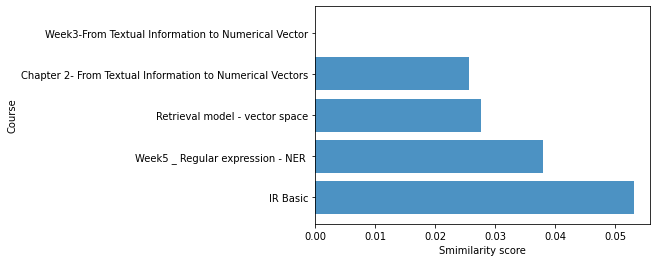

In [52]:
from scipy.spatial.distance import cosine
query_2={"Understand Retrieval Model, regular expression and textual information"}
#query_token_raw_2= list(jieba.cut(query_2))
query_token_raw_2 = (ws_driver(query_2, use_delim=True, batch_size=256, max_length=128))

flat_list = list()
query_token_raw_2 = flatten_list(query_token_raw_2)

query_token_2 = set(query_token_raw_2).intersection(bag_words_2)
#[term for term in query_token_raw_2 if term in bag_words_2]
tfidf_query_2 =compute_tfidf_query(list(query_token_2),bag_words_idf_2) #calculate tfidf for query text

# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf_2["query"]=tfidf_query_2
import pandas as pd
tfidf_df_2 = pd.DataFrame(tfidf_2).transpose()
tfidf_df_2= tfidf_df_2.fillna(0) # replace all NaN by zero
cosine_sim ={}
for row in tfidf_df_2.index:
  if row != "query":
    cosine_sim[row]= 1-cosine(tfidf_df_2.loc[row],tfidf_df_2.loc["query"])

# the top 10 relevant document
cosine_sim_top20 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:20])

#plot barchart
import matplotlib.pyplot as plt
data = cosine_sim_top20
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Course')
# save graph
plt.savefig(mydrive+"barchart.png", bbox_inches='tight', dpi=1200)
plt.show()

In [53]:
bag_words_idf_2

{'Verb': 0.6989700043360189,
 'does': 0.6989700043360189,
 'Corp. by': 0.6989700043360189,
 ' 2002': 0.6989700043360189,
 '  Stream': 0.6989700043360189,
 'Additional': 0.6989700043360189,
 'tiword': 0.6989700043360189,
 ' are so highly': 0.6989700043360189,
 ' sure': 0.6989700043360189,
 ' columns': 0.6989700043360189,
 '\x0c2. Word': 0.6989700043360189,
 ' cells of': 0.6989700043360189,
 ' others. It': 0.6989700043360189,
 ' Tokens': 0.6989700043360189,
 '//github.com/ckiplab/ckiptagger': 0.6989700043360189,
 ' constant': 0.6989700043360189,
 ' b d g k m': 0.6989700043360189,
 ' company)': 0.6989700043360189,
 ' large': 0.22184874961635637,
 'tions': 0.6989700043360189,
 ' languages': 0.3979400086720376,
 ' “in': 0.6989700043360189,
 ' on text': 0.6989700043360189,
 '個': 0.6989700043360189,
 ' Write': 0.3979400086720376,
 'tokens. The': 0.6989700043360189,
 'groups': 0.6989700043360189,
 '40': 0.6989700043360189,
 ' 15': 0.6989700043360189,
 ' infinitely': 0.6989700043360189,
 'progr